In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,".")); Pkg.instantiate();
using LinearAlgebra;
using Plots;
using StaticArrays;
using SparseArrays;
using SparsityDetection;
using FiniteDiff;
using SparseDiffTools;
using ForwardDiff;
using RobotZoo;
using RobotDynamics;
using MeshCat;
using TrajOptPlots;
using MathOptInterface;
const MOI = MathOptInterface
using Ipopt;
using RigidBodyDynamics;
using Symbolics;

 Activating environment at `C:\Users\brand\OneDrive\Documents\College Stuff\16-745\final-project\Project.toml`


We know the dynamics are of the following:
            $$q = \begin{bmatrix}
                  x_{foot}    \\
                  y_{foot}   \\
                  \alpha \\
                  \beta  \\
                  \end{bmatrix}$$
where $\alpha$ is the top revolute joint and $\beta$ is the middle revolute joint
And normally for a single dynamics phase,
$$ dx = \delta_{(x, 1)} f_{1}(x, u) + \delta_{(x, 2)} f_{2}(x, u)$$

which is pretty much a guard function.

           
           
           
           
           

In [175]:
struct Hopper
    ml
    l
    function Hopper(ml, l)
        new(ml, l)
    end
end



m1 = 1.0
m2 = 1.0
ℓ1 = 1.0
ℓ2 = 1.0
J1 = (1.0/12)*m1*ℓ1*ℓ1
J2 = (1.0/12)*m2*ℓ2*ℓ2


function link2_kinematics(q)
    x1 = q[1]
    y1 = q[2]
    θ1 = q[3]
    θ2 = q[4]
    
    
    x2 = x1 - 0.5*ℓ1*sin(θ1) - 0.5*ℓ2*sin(θ2)
    y2 = y1 + 0.5*ℓ1*cos(θ1) + 0.5*ℓ2*cos(θ2)
    
    return [x2; y2]
end

function foot_kinematics(q)
    x1 = q[1]
    y1 = q[2]
    θ1 = q[3]
    
    
    xf = x1 + 0.5*ℓ1*sin(θ1)
    yf = y1 - 0.5*ℓ1*cos(θ1)
    
    return [xf; yf]
end



#Fast Kinematics Functions

@variables q[1:4]
@variables q̇[1:4]
@variables u[1:2] #torque inputs on links 1 and 2
@variables f[1:2] #contact force on foot (end of link 1)

klink2 = link2_kinematics(q)
klink2_expr = Symbolics.build_function(klink2, q)
k2_func = eval(klink2_expr[1])

kfoot = foot_kinematics(q)
kfoot_expr = Symbolics.build_function(kfoot, q)
kfoot_func = eval(kfoot_expr[1])

#Kinematics Jacobians

J2 = Symbolics.jacobian(klink2, q, simplify = true)
Jf = Symbolics.jacobian(kfoot, q, simplify = true)

J2_expr = Symbolics.build_function(J2, q)
Jf_expr = Symbolics.build_function(Jf, q)

J2_func = eval(J2_expr[1])
Jf_func = eval(Jf_expr[1])

#Lagrangian
function lagrangian(q, q̇)
    L = 0.0
    g = 9.81

    # Link 1
    L += 0.5*m1*transpose(q̇[1:2])*q̇[1:2] + 0.5*J1*q̇[3]*q̇[3] #kinetic energy
    L -= m1*g*q[2] #potential energy

    # Link 2
    v2 = J2_func(q)*q̇
    L += 0.5*m2*transpose(v2)*v2
    L -= m2*g*k2_func(q)[2]

    return L
end

L = lagrangian(q, q̇)
dLq = Symbolics.gradient(L, q, simplify = true)
dLq̇ = Symbolics.gradient(L, q̇, simplify = true)
d2L = Symbolics.hessian(L, [q; q̇], simplify = true)

#mass matrix
M = d2L[4 .+ (1:4), 4 .+ (1:4)]
M = simplify.(M)

#dynamics bias
C = d2L[4 .+ (1:4), 1:4] * q̇ - dLq
C = simplify.(C)

#input jacobian
B = [0.0 0.0; 0.0 0.0; 1.0 0.0; 0.0 1.0]

# continuous-time dynamics
ẋ = [q̇; M\(B*u + transpose(Jf)*f - C)]
ẋ = simplify.(ẋ)

ẋ_expr = Symbolics.build_function(ẋ, [q; q̇], u, f)

dynamics = eval(ẋ_expr[1])

# continuous-time dynamics derivatives

dẋ = Symbolics.jacobian(ẋ, [q; q̇; u; f]);
dx = simplify(dẋ[:,1:8])
du = simplify(dẋ[:,9:10])
df = simplify(dẋ[:,11:12])

Ac_expr = Symbolics.build_function(dx, [q; q̇], u, f)
Bc_expr = Symbolics.build_function(du, [q; q̇], u, f)
Cc_expr = Symbolics.build_function(df, [q; q̇], u, f)

Ac = eval(Ac_expr[1])
Bc = eval(Bc_expr[1])
Cc = eval(Cc_expr[1])

#Discrete-time dynamics with foot pinned at the origin
function implicit_euler(x,u,f,h; inair=false)
    xn = copy(x)
    if inair
        r = xn - x - h.*dynamics(xn,u,f)
    else
        r = [xn - x - h.*dynamics(xn,u,f); foot_kinematics(xn)]
    end
   #  println(r)
    
    while maximum(abs.(r)) > 1e-6
        if inair
            dr = I-h.*Ac(xn,u,f)
            # println(size(dr))
            dx = -dr\r
            xn += dx
            r = xn - x - h.*dynamics(xn,u,f)
        else
            dr = [I-h.*Ac(xn,u,f) -h.*Cc(xn,u,f); Jf_func(xn[1:4]) zeros(2,6)]
            dz = -dr\r
            xn += dz[1:8]
            f += dz[9:10]
            r = [xn - x - h.*dynamics(xn,u,f); foot_kinematics(xn)]
        end
    end
    
    return xn, f
end

function num_duals(nlp)
    return nlp.cinds[end][end]
end


function num_primals(nlp)
    return nlp.N*8 + (nlp.N - 1)*2 + nlp.N*2
end


function jump_map(x)
    return [x[1] + 0.1; x[2:8]]
end

jump_map (generic function with 1 method)

# Controls Part: Solving an NLP using IPOPT
We want to formulate the problem as follows:
$$ min_{z=1:N} \frac{1}{2}(z_{N}-z_{N, ref})^{T} Q_{N} (z_{N}-z_{N, ref}) + \sum \frac{1}{2}(z_{n}-z_{n, ref})^{T} Q_{n} (z_{n}-z_{n, ref}) + q_{n}^{T}(z_{n}-z_{n, ref})$$ 
where the combined $$ z = \begin{bmatrix} u_{1} \\ x_{2} \\ u_{2} \\ . \\ .\\ . \\ x_{N} \end{bmatrix}$$

To do this, we need to solve for the piece $c(z)$. The solver (IPOPT) should handle the rest for us.

$$c(z) = \begin{bmatrix} c_{dyn}\\ c_{\alpha} \\ c_{>0} \\ c_{y_{nref}} \\ c_{init} \\ c_{term}\end{bmatrix}$$
  
where
$$c_{>0} \rightarrow{} y_{ref} = 0 \text{ (in stance mode)}$$
$$c_{\alpha} \rightarrow{} \frac{\pi}{2} \leq \alpha \leq \pi$$
$$c_{y_{nref}} \rightarrow {} y_{nref} > y_{ref} $$
$c_{dyn}$ is the usual dynamics equality constraint

NOTE: mode == 1 means we are on the ground. modes = 2 means we are in flight

In [144]:
# Some useful functions
# Find the LQR cost of something
function LQRcost(nlp, Z)
    J = 0.0
    X, U, F = unpack(nlp, Z)
    R = nlp.R
    Q = nlp.Q
    Qf = nlp.Qf
    xf = nlp.xf
    uf = zeros(length(U[1]))
    # Some useful constants
    c = 0.5*xf'*Q*xf + 0.5*uf'*R*uf
    q = -Q*xf
    r = -R*uf
    for i = 1:nlp.N-1
        x = X[i]
        u = U[i]
        # Stage cost
        J += 0.5*(x'*Q*x + u'*R*u) + q'*x + r'*u + c
    end
    x = X[end]
    # Terminal cost
    J += 0.5*x'*Qf*x + q'*x + c
    return J
end


function cost_grad!(nlp, grad, Z)
    X, U, F = unpack(nlp, Z)
    Q = nlp.Q
    R = nlp.R
    Q = nlp.Q
    Qf = nlp.Qf
    xf = nlp.xf
    N = nlp.N
    uf = zeros(length(U[1]))
    # Some useful constants
    q = -Q*xf
    r = -R*uf
    for i = 1:N-1
        grad[nlp.xinds[i]] .= Q*X[i] + q
        grad[nlp.uinds[i]] .= R*U[i] + r
    end
    grad[nlp.xinds[end]] .= Qf*X[end]+ q
    return nothing
end
    

function unpack(nlp, Z)
    # println(size(Z))
    X = [Z[inds] for inds in nlp.xinds]
    U = [Z[inds] for inds in nlp.uinds]
    F = [Z[inds] for inds in nlp.finds]
    return X, U, F
end


function nonlp_unpack(Z, xinds, uinds, finds)
    # println(size(Z))
    X = [Z[inds] for inds in xinds]
    U = [Z[inds] for inds in uinds]
    F = [Z[inds] for inds in finds]
    return X, U, F
end


function pack(nlp, X, U, F)
    println(nlp.N-1)
    # println(λ)
    Z = zeros(num_primals(nlp))
    # println(length(Z))
    for i = 1:(nlp.N-1)
        Z[nlp.xinds[i]] .= X[i]
        Z[nlp.uinds[i]] .= U[i]
        Z[nlp.finds[i]] .= F[i]
    end
    Z[nlp.xinds[end]] .= X[end]
    # Z[nlp.finds[end]] .= λ[end]
    return Z
end
        
        

# First, we want to define the problem. The length of z is going to be 10*N
mutable struct HybridNLP <: MOI.AbstractNLPEvaluator
    model       # dynamics model, hopper
    Q           # x cost matrix
    R           # u cost matrix
    Qf          # xf terminal cost
    x0          # initial condition
    xf          # terminal condition
    mSteps      # number of timesteps in each mode
    modes       # vector of modes of each thing 
    zL          # lower bounds on primals
    zU          # upper bounds on primals
    lb          # lower bounds on constraints
    ub          # upper bounds on constraints
    xinds       # indices of x values
    uinds       # indices of u values
    finds       # indices of lambdas
    cinds       # indices of constraints
    tf          # final time
    N           # number of knot points
    h           # timestep
    sparseInds  # indices for a sparse structure
    function HybridNLP(model, Q, R, Qf, tf, N, mSteps, x0, xf, h; fStart=false)
        xLen = 8
        uLen = 2
        fLen = 2
        zLen = xLen + uLen + fLen
        num_prim = xLen*N + fLen*N + uLen*(N-1) 
        # Indexes of x and u, given zLen = xLen + uLen
        xinds = [SVector{xLen}((i-1)*(zLen) .+ (1:xLen)) for i=1:N]
        finds = [SVector{uLen}((i-1)*(zLen) .+ ((xLen+1):(xLen+fLen))) for i=1:N]
        uinds = [SVector{fLen}((i-1)*(zLen) .+ ((xLen+fLen+1):zLen)) for i=1:N-1]
        
#         println(xinds)
#         println(uinds)
#         println(finds)
        # Calculate hybrid method modes
        modes = zeros(N)
        if fStart
            change = -1
            curMode = 2
        else
            change = 1
            curMode = 1
        end
        
        for i = 1:N
            modes[i] = curMode
            if mod(i, mSteps) == 0
                curMode += change
                change = -change
            end
        end
        
        # Constraint indexing
        cDInds = 1:(xLen*(N - 1))
        
       
        
#         For the real test, uncomment the following
        cStanceInds = (xLen*(N - 1) + 1):(xLen*(N - 1) + 2*N)
        cInitInds = (xLen*(N - 1) + 2*N + 1):(xLen*(N) + 2*N)
        cTermInds = (xLen*(N) + 2*N + 1):(xLen*(N+1) + 2*N)
        cinds = [cDInds, cStanceInds, cInitInds, cTermInds]
        
    
        
        # Just dynamics test, uncomment the following
#         cStanceInds = (xLen*(N - 1) + 1):(xLen*(N - 1) + 2*N)
#         cInitInds = (xLen*(N - 1) + 2*N + 1):(xLen*(N) + 2*N)
#         cControlInds = (xLen*(N) + 2*N + 1):(xLen*(N) + 4*N - 2)
#         cinds = [cDInds, cStanceInds, cInitInds, cControlInds]
        
        # Setting up upper and lower bounds
        lb = zeros(cinds[end][end])
        ub = zeros(cinds[end][end])
        
# #         In the real thing, uncommonet the following
#         stanceUpper = reshape(view(ub, cStanceInds), 2, N)
#         stanceLower = reshape(view(lb, cStanceInds), 2, N)    
#         for i = 1:N
#             if modes[i] == 1
#                 stanceUpper[:, i] .= [Inf, Inf]
#                 stanceLower[1, i] = -Inf
#             end
#         end
        
        tempC = zeros(cinds[end][end])
        
        # Calculate the number of primal variables
        zL = fill(-Inf, num_prim)
        zU = fill(Inf, num_prim)
        
        new(model, Q, R, Qf, x0, xf, mSteps, modes, zL, zU, lb, ub, xinds, uinds, finds, cinds, tf, N, h)
    end
end

In [ ]:
# Test the HybridNlp formulator
begin
    uSize = 2
    xSize = 8
    lSize = 2
    x0 = zeros(xSize)
    xf = zeros(xSize)
    u0 = zeros(uSize)
    f0 = zeros(lSize)
    
    hopper = Hopper(1, 1)
    h = 0.01
    mSteps = 5
    Qf = I(8) * 0.01
    Q = Qf
    R = I(2) * 0.1
    N = 5
    tf = N*h
    
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, h, fStart=true)
    println(p.finds)
    
    # Test pack

    X = [SVector{8}(x0 .+ 1) for i=1:N]
    U = [SVector{2}(u0 .- 1) for i=1:N-1]
    F = [SVector{2}(f0) for i=1:N-1]
    # println(N*length(X[1]) + (N - 1)*length(U[1]))
    Z = pack(p, X, U, F)
    println("Packed Zs: ", length(Z))
    rX, rU, rF = unpack(p, Z)
    println("Unpacked Xs: ", rX)
    println("Unpacked Us: ", rU)
    println("Unpacked Fs: ", rF)
    J = LQRcost(p, Z)
    println("Cost: ", J)
    cG = zeros(num_primals(p))
    cost_grad!(p, cG, Z)
    println("Cost Gradient: ", cG)
    # println(p.lb)
    println(length(p.lb))
    println(p.cinds[end][end])
    println(p.cinds)
end

In [180]:
# Dynamics constraint, want 5 in stance and 5 in flight. Jump map is on flight's number 5
function dynamics_constraints(nlp, Z)
    X, U, F = unpack(nlp, Z)
    N = nlp.N
    h = nlp.h
    modes = nlp.modes
    xLen = length(X[1])
    # println(N)
    d = zeros(eltype(Z), xLen, N-1)
    # d = reshape(view(c, nlp.cinds[1]), xLen, N-1)
    for i = 1:N-1
#         if mod(i, mSteps) == 0 and modes[i] == 2
#             d[:, i] .= jump_map(nlp.x0)
#         else
#             d[:, i] .= X[i] + h.*dynamics(X[i+1],U[i],F[i]) - X[i+1]
#         end
        d[:, i] .= X[i] + h.*dynamics(X[i+1],U[i],F[i]) - X[i+1]
    end
    d = reshape(d, (xLen*(N-1)))
    return d # checking is easier
end


function dynamics_constraints!(nlp, Z::AbstractVector, c::AbstractVector)
    X, U, F = unpack(nlp, Z)
    N = nlp.N
    h = nlp.h
    modes = nlp.modes
    xLen = length(X[1])
    # println(N)
    d = reshape(view(c, nlp.cinds[1]), xLen, N-1)
    for i = 1:N-1
#         if mod(i, mSteps) == 0 and modes[i] == 2
#             d[:, i] .= jump_map(nlp.x0)
#         else
#             d[:, i] .= X[i] + h.*dynamics(X[i+1],U[i],F[i]) - X[i+1]
#         end
        d[:, i] .= X[i] + h.*dynamics(X[i+1],U[i],F[i]) - X[i+1]
    end
    return nothing # checking is easier
end


function stance_constraints!(nlp, Z, c)
    X, U, F = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    sInds = nlp.cinds[2]
    s = reshape(view(c, sInds), 2, N)
    for i = 1:N
        if modes[i] == 1
            xk = X[i]
            footX = kfoot_func(xk)
            s[1, i] = xk[5] + 0.5*nlp.model.l*cos(xk[3])*xk[7]
            s[2, i] = footX[2]
        else
            s[:, i] = F[i] 
        end
    end
    return nothing
end


function stance_constraints(nlp, Z)
    X, U, F = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    s = zeros(eltype(Z), 2, N)
    for i = 1:N
        if modes[i] == 1
            xk = X[i]
            footX = kfoot_func(xk)
            s[1, i] = xk[5] + 0.5*nlp.model.l*cos(xk[3])*xk[7]
            s[2, i] = footX[2]
        else
            s[:, i] = F[i] 
        end
    end
    s = reshape(s, (2*N))
    return s
end

function control_constraints!(nlp, Z, c)
    X, U, F = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    ucon = reshape(view(c, nlp.cinds[4]), 2, N-1)
    for i = 1:N-1
        ucon[:, i] .= U[i]
    end
    ucon = reshape(ucon, (2*(N-1), 1))
    return ucon
end


function control_constraints(nlp, Z)
    X, U, F = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    ucon = zeros(eltype(Z), 2, N-1)
    for i = 1:N-1
        ucon[:, i] .= U[i]
    end
    ucon = reshape(ucon, (2*(N-1), 1))
    return ucon
end


function init_constraints!(nlp, Z, c)
    X, U = unpack(nlp, Z)
    n = length(X[1])
    modes = nlp.modes
    # N = nlp.N
    init = reshape(view(c, nlp.cinds[3]), n)
    init .= X[1] - nlp.x0
    return nothing
end


function init_constraints(nlp, Z)
    X, U = unpack(nlp, Z)
    n = length(X[1])
    init = zeros(eltype(Z), n)
    init .= X[1] - nlp.x0
    return init
end


function term_constraints!(nlp, Z, c)
    X, U, F = unpack(nlp, Z)
    n = length(X[1])
    init = reshape(view(c, nlp.cinds[4]), n)
    init .= X[end] - nlp.xf
    return nothing
end
    

function term_constraints(nlp, Z)
    X, U, F = unpack(nlp, Z)
    n = length(X[1])
    init = zeros(eltype(Z), n)
    init .= X[end] - nlp.xf
    return init
end


function constraints!(nlp, Z, c)
    dynamics_constraints!(nlp, Z, c)
    init_constraints!(nlp, Z, c)
    stance_constraints!(nlp, Z, c)
    term_constraints!(nlp, Z, c)
    
#     # Uncomment for dynamics
#     control_constraints!(nlp, Z, c)
end


function test_constraints!(c, Z, nlp)
    dynamics_constraints!(nlp, Z, c)
    init_constraints!(nlp, Z, c)
    stance_constraints!(nlp, Z, c)
    
#     # Uncomment for dynamics
#     control_constraints!(nlp, Z, c)
end


# No NLP stuff for sparsity structure finding
function nonlp_d_constraints(Z, N, h, modes, xinds, uinds, finds)
    X, U, F = nonlp_unpack(Z, xinds, uinds, finds)
    xLen = length(X[1])
    # println(N)
    d = zeros(eltype(Z), xLen, N-1)
    # d = reshape(view(c, nlp.cinds[1]), xLen, N-1)
    for i = 1:N-1
        d[:, i] .= X[i] + h.*dynamics(X[i+1],U[i],F[i]) - X[i+1]
    end
    d = reshape(d, (xLen*(N-1)))
    return d
end

function nonlp_i_constraints(Z, xinds, uinds, finds, x0)
    X, U, F = nonlp_unpack(Z, xinds, uinds, finds)
    n = length(X[1])
    init = zeros(eltype(Z), n)
    init .= X[1] - x0
    return init
end


function nonlp_s_constraints(Z, N, modes, xinds, uinds, finds)
    X, U, F = nonlp_unpack(Z, xinds, uinds, finds)
    s = zeros(eltype(Z), 2, N)
    for i = 1:N
        if modes[i] == 1
            xk = X[i]
            footX = kfoot_func(xk)
            s[1, i] = xk[5] + 0.5*cos(xk[3])*xk[7]
            s[2, i] = footX[2]
        else
            s[:, i] = F[i] 
        end
    end
    s = reshape(s, (2*N))
    return s
end


function nonlp_constraints!(Z, N, modes, xinds, uinds, finds, cinds, h, x0, c)
    c[cinds[1]] .= nonlp_d_constraints(Z, N, h, modes, xinds, uinds, finds)
    c[cinds[2]] .= nonlp_s_constraints(Z, N, modes, xinds, uinds, finds)
    c[cinds[3]] .= nonlp_i_constraints(Z, xinds, uinds, finds, x0)
    return nothing
end


function constraints(Z, nlp)
    c = zero(num_duals(nlp))
    dynamics_constraints!(nlp, Z, c)
    init_constraints!(nlp, Z, c)
    stance_constraints!(nlp, Z, c)
    return c
    
#     # Uncomment for dynamics
#     control_constraints!(nlp, Z, c)
end


# For this to work, you HAVE to set N each time or else you'll be boned
function sparse_constraints!(c, Z)
    # Constants
    xLen = 8
    uLen = 2
    fLen = 2
    zLen = xLen + uLen + fLen
    

    # Variables: CHANGE BETWEEN RUNS
    N = 75
    fStart = false
    h = 0.01
    t1 = pi/4
    t2 = -pi/4
    x0 = [-0.5*sin(t1); 0.5*cos(t1); t1; t2; 0.0; 0.0; 0.0; 0.0]
    
    # Keep these the same
    num_prim = xLen*N + fLen*N + uLen*(N-1) 
    xinds = [SVector{xLen}((i-1)*(zLen) .+ (1:xLen)) for i=1:N]
    finds = [SVector{uLen}((i-1)*(zLen) .+ ((xLen+1):(xLen+fLen))) for i=1:N]
    uinds = [SVector{fLen}((i-1)*(zLen) .+ ((xLen+fLen+1):zLen)) for i=1:N-1]
    
    modes = zeros(N)
    if fStart
        change = -1
        curMode = 2
    else
        change = 1
        curMode = 1
    end

    for i = 1:N
        modes[i] = curMode
        if mod(i, mSteps) == 0
            curMode += change
            change = -change
        end
    end

    # Constraint indexing
    cDInds = 1:(xLen*(N - 1))
    cStanceInds = (xLen*(N - 1) + 1):(xLen*(N - 1) + 2*N)
    cInitInds = (xLen*(N - 1) + 2*N + 1):(xLen*(N) + 2*N)
    cinds = [cDInds, cStanceInds, cInitInds]
    
    
    nonlp_constraints!(Z, N, modes, xinds, uinds, finds, cinds, h, x0, c)
end
    
    

sparse_constraints! (generic function with 1 method)

In [ ]:
# Constraints tests
begin
    uSize = 2
    xSize = 8
    lSize = 2
    x0 = zeros(xSize)
    xf = zeros(xSize)
    u0 = zeros(uSize)
    f0 = zeros(lSize)
    
    t1 = 0.0
    t2 = 0.0
    x0 = [-0.5*sin(t1); 0.5*cos(t1); t1; t2; 0.0; 0.0; 0.0; 0.0]

    
    hopper = Hopper(1, 1)
    mSteps = 5
    Qf = I(8) * 0.01
    Q = Qf
    R = I(2)
    N = 75
    h = 0.01
    tf = N*h
    
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, h, fStart=false)
    println(kfoot_func(x0))
    println(p.modes)
    
    # Xref, Uref = ref_traj(p, 0.1)
    # Xref, Uref = ref_traj(p, 0.1)
    X = [SVector{8}(rand(xSize).+20) for i=1:N]
    U = [SVector{2}(rand(uSize).+20) for i=1:N-1]
    F = [SVector{2}(rand(lSize).+20) for i=1:N]
    # println(N*length(X[1]) + (N - 1)*length(U[1]))
    X[1] = rand(8)*20
    Z = pack(p, X, U, F)
    
    println(X)
    # Z = pack(p, Xref, Uref)
    c = zeros(num_duals(p))
    println("c: ",length(c))
    constraints!(p, Z, c)
    println("Dynamics Constraints")
    println(c[p.cinds[1]])
    
    println("Initial Constraints")
    println(c[p.cinds[3]])
    # println(c)
    
    println("Non-NLP Constraints")
    a = zeros(num_duals(p))
    sparse_constraints!(a, Z)
    # nonlp_constraints!(Z, p.N, p.modes, p.xinds, p.uinds, p.finds, p.cinds, a, h, @SVector zeros(8))
    println(c)
    println(norm(a .- c))
    # println(findall(!iszero, a))
    
end

In [146]:
# Put together the Jacobians
function dynamics_jacobian(nlp, Z)
    return ForwardDiff.jacobian(z->dynamics_constraints(nlp, z), Z)
end


function alpha_jacobian(nlp, Z)
    # c = zeros(eltype(z), nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->vec(alpha_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function stance_jacobian(nlp, Z)
    # c = zeros(nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->stance_constraints(nlp, z), Z)
end


function head_jacobian(nlp, Z)
    return ForwardDiff.jacobian(z->vec(head_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function init_jacobian(nlp, Z)
    # c = zeros(nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->init_constraints(nlp, z), Z)
end


function term_jacobian(nlp, Z)
    # c = zeros(nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->term_constraints(nlp, z), Z)
end


function control_jacobian(nlp, Z)
    return ForwardDiff.jacobian(z->control_constraints(nlp, z), Z)
end


function constraint_jacobian!(nlp, Z, jac)
    # Just dynamics test
    d_jac = dynamics_jacobian(nlp, Z)
    s_jac = stance_jacobian(nlp, Z)
    i_jac = init_jacobian(nlp, Z)
    t_jac = term_jacobian(nlp, Z)

    jac[nlp.cinds[1], :] .= d_jac
    jac[nlp.cinds[2], :] .= s_jac
    jac[nlp.cinds[3], :] .= i_jac
    jac[nlp.cinds[4], :] .= t_jac
    
#     # if doing dynamics only
#     c_jac = control_jacobian(nlp, Z)
#     jac[nlp.cinds[4], :] .= c_jac
    
    return nothing
end


function setup_jacobian!(nlp, Z, jac)
    # Just dynamics test
    d_jac = dynamics_jacobian(nlp, Z)
    s_jac = stance_jacobian(nlp, Z)
    i_jac = init_jacobian(nlp, Z)

    jac[nlp.cinds[1], :] .= d_jac
    jac[nlp.cinds[2], :] .= s_jac
    jac[nlp.cinds[3], :] .= i_jac
    
#     # if doing dynamics only
#     c_jac = control_jacobian(nlp, Z)
#     jac[nlp.cinds[4], :] .= c_jac
    
    return nothing
end


function sparse_pattern(nlp, Z)
    c = zeros(num_duals(nlp))
    sparseInds = nlp.sparseInds
    sLen = length(sparseInds)
    spjac = spzeros(num_duals(nlp), num_primals(nlp))
    for i = 1:sLen
        spInd = sparseInds[i]
        spjac[spInd[1], spInd[2]] = 1.0
        # J[i] = spInd[2]
    end
    return spjac
end


function sparse_jacobian!(nlp, Z, sparsejac)
    colors = matrix_colors(sparsejac)
    sparsecache = FiniteDiff.JacobianCache(Z,colorvec=colors,sparsity=sparsejac)
    FiniteDiff.finite_difference_jacobian!(sparsejac, sparse_constraints!, Z, sparsecache)
end


function compute_sparse_jacobian!(nlp, Z, jac)
    spjac = sparse_pattern(nlp, Z)
    sparse_jacobian!(nlp, Z, spjac)
    jac .= spjac
    return nothing
end
    

function fd_constraint_jacobian!(nlp, Z, jac)
    m_nlp = num_duals(nlp)
    # cons = zeros(m_nlp)
    plusDeltaC = zeros(m_nlp)
    minusDeltaC = zeros(m_nlp)
    delta = 1e-7
    for i = 1:length(Z)
        plusZ = copy(Z)
        minusZ = copy(Z)
        plusZ[i] += delta
        minusZ[i] -= delta
        constraints!(p, plusZ, plusDeltaC)
        constraints!(p, minusZ, minusDeltaC)
        jac[:, i] .= (plusDeltaC - minusDeltaC) ./ (2*delta)
    end
end

function set_sparse_inds!(nlp)
    uSize = 2
    xSize = 8
    lSize = 2
    
    N = nlp.N
    X = [SVector{8}(rand(xSize).+15) for i=1:N]
    U = [SVector{2}(rand(uSize).+15) for i=1:N-1]
    F = [SVector{2}(rand(lSize).+15) for i=1:N]
    Z = pack(nlp, X, U, F)
    
    jac = zeros(num_duals(nlp), num_primals(nlp))

    constraint_jacobian!(nlp, Z, jac)
    goodInds = Tuple.(findall(!iszero, jac))
    nlp.sparseInds = goodInds
end

function throwaway_test(a, b)
    for i = 1:length(a)
        a[i] = b[i, 1] * 2.0 - b[i, 2] * 3.0
    end
end

throwaway_test (generic function with 1 method)

In [ ]:
# Jac Test
begin
    uSize = 2
    xSize = 8
    lSize = 2
    x0 = zeros(xSize)
    xf = zeros(xSize)
    u0 = zeros(uSize)
    λ0 = zeros(lSize)
    
    hopper = Hopper(1, 1)
    h = 0.01
    mSteps = 5
    Qf = I(8) * 0.01
    Q = Qf
    R = I(2)
    N = 75
    tf = N*h
    
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, h, fStart=false)
    
    
    # Xref, Uref = ref_traj(p, 0.1)
    X = [SVector{8}(rand(xSize).+20) for i=1:N]
    U = [SVector{2}(rand(uSize).+20) for i=1:N-1]
    F = [SVector{2}(rand(lSize).+20) for i=1:N]

    Z = pack(p, X, U, F)
    m_nlp = num_duals(p)
    n_nlp = num_primals(p)
    mjac = zeros(m_nlp, n_nlp)
    njac = copy(mjac)
    println("m: ", m_nlp)
    println("n: ", n_nlp)
    # println(dynamics_jacobian(p, Z))
    # # constraint_jacobian!(p, Z, mjac)
    # println(mjac)
    println(size(Z))
    
#     @time fd_constraint_jacobian!(p, Z, mjac)
#     println(@time fd_constraint_jacobian!(p, Z, mjac))
    # println(mjac)
    
    println(term_constraints(p, Z))
    
    @time constraint_jacobian!(p, Z, njac)
    println(@time constraint_jacobian!(p, Z, njac))
    constraint_jacobian!(p, Z, njac)
    println(size(njac))
    
#     set_sparse_inds!(p)
#    #  println(p.sparseInds)
# #    println(p.sparseInds)
#     # spjac = sparse_pattern(p, Z)
#     spjac = zeros(m_nlp, n_nlp)
#     a = zeros(m_nlp)
#     sparse_constraints!(a, Z)
#     println(size(spjac))
#     # println(size(a))
#     # println(num_primals(p))
#     @time compute_sparse_jacobian!(p, Z, spjac)
#     println(@time compute_sparse_jacobian!(p, Z, spjac))
#     println(norm(spjac .- njac))
#     println(size(spjac))
    
    # println(p.sparseInds)
    
    
    
end

In [147]:


# IPOPT Guts, borrowed from MOI.jl

function MOI.eval_objective(prob::HybridNLP, x)
    return LQRcost(prob, x)
end

function MOI.eval_objective_gradient(prob::HybridNLP, grad_f, x)
    cost_grad!(prob, grad_f, x)
    return nothing
end

function MOI.eval_constraint(prob::HybridNLP, g, x)
    # sparse_constraints!(g, x)
    constraints!(prob, x, g)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::HybridNLP, vec, x)
    m_nlp = num_duals(prob)
    n_nlp = num_primals(prob)
    jac = reshape(vec, m_nlp, n_nlp)
    
    # ForwardDiff.jacobian!(jac, (x,c) -> constraints!(prob, x, c), x, zeros(m_nlp))
#     spjac = sparse_pattern(prob, x)
#     sparse_jacobian!(prob, x, spjac)
#     vec .= reshape(spjac, m_nlp*n_nlp)
    constraint_jacobian!(prob, x, jac)
    return nothing
end

function MOI.features_available(prob::HybridNLP)
    return [:Grad, :Jac]
end

MOI.initialize(prob::HybridNLP, features) = nothing
MOI.jacobian_structure(nlp::HybridNLP) = vec(Tuple.(CartesianIndices(zeros(num_duals(nlp), num_primals(nlp)))))

"""
    solve(x0, nlp::HybridNlp; tol, c_tol, max_iter)

Solve the NLP `nlp` using Ipopt via MathOptInterface, providing `x0` as an initial guess.

# Keyword Arguments
The following arguments are sent to Ipopt
* `tol`: overall optimality tolerance
* `c_tol`: constraint feasibility tolerance
* `max_iter`: maximum number of solver iterations
"""
function solve(x0,prob::HybridNLP;
        tol=1.0e-2,c_tol=1.0e-2,max_iter=100)
    println("Creating Problem Parameters...")
    n_nlp, m_nlp = num_primals(prob), num_duals(prob)
    x_l, x_u = fill(-Inf,n_nlp), fill(+Inf,n_nlp)
    c_l, c_u = prob.lb, prob.ub

    println("Creating NLP Block Data...")
    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    has_objective = true
    block_data = MOI.NLPBlockData(nlp_bounds, prob, has_objective)

    println("Creating Ipopt...")
    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol
    # solver.options["check_derivatives_for_naninf"] = "yes"
    solver.options["bound_relax_factor"] = 1e-5

    x = MOI.add_variables(solver, n_nlp)

    println("Adding constraints...")
    for i = 1:n_nlp
        xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    println("Starting Ipopt Solve...")
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res, solver
end

solve

## Reference trajectory stuff


In [236]:
function same_traj(x, N)
    xs = zeros(length(x), N)
    for i = 1:N
        xs[:, i] .= x
    end
    return xs
end


function single_hop(nlp, x, N, h; jHeight = -1.0, fDist = 0.0)
    xs = zeros(length(x), N)
    modes = nlp.modes
    mSteps = nlp.mSteps
    firstHop = true
    counter = 1
    
    hPick = zeros(8)
    hPick[2] = 1.0
    yvPick = zeros(8)
    yvPick[6] = 1.0
    # xPick = zeros(8)
    # Reference it as a parabola, with highest in the middle
    g = 9.81
    
    tpeak = mSteps*h/2
    
    println(x)
    xVel = fDist / (tpeak * 2.0)
    println(xVel)
    
    if jHeight >= 0.0
        yVel = jHeight / tpeak
        fallA = yVel / tpeak
    else
        yVel = 1/2 * g * mSteps * h
        fallA = g
    end
    # println("Yv", yVel)
    currX = x[1]
    for i = 1:N
        mode = modes[i]
        if mode == 1
            xs[:, i] .= x
            xs[1, i] = currX
            counter = 1
        else
            tPass = counter*h
            if counter <= mSteps/2
                xs[:, i] .= x .+ hPick*(yVel*tPass) + yvPick*(yVel - fallA*tPass)
            else
                xs[:, i] .= x .+ hPick*(yVel*tpeak - yVel*(tPass-tpeak)) + yvPick*(yVel - fallA*tPass)
            end
            currX = currX .+ xVel*h
            xs[1, i] = currX
            xs[5, i] = xVel
            # println(xVel)
            counter += 1
        end
    end
    return xs
end
                

function flip(nlp, x, N, h; jHeight = -1.0, fDist = 0.0, flipDir = -1.0)
    xs = zeros(length(x), N)
    modes = nlp.modes
    mSteps = nlp.mSteps
    firstHop = true
    counter = 1
    
    hPick = zeros(8)
    hPick[2] = 1.0
    yvPick = zeros(8)
    yvPick[6] = 1.0
    # xPick = zeros(8)
    # Reference it as a parabola, with highest in the middle
    g = 9.81
    
    tpeak = mSteps*h/2
    
    xVel = fDist / (tpeak * 2.0)
    flipVel = flipDir*2*pi / (tpeak * 2.0)

    
    if jHeight >= 0.0
        yVel = jHeight / tpeak
        fallA = yVel / tpeak
    else
        yVel = 1/2 * g * mSteps * h
        fallA = g
    end
    # println("Yv", yVel)
    currX = x[1]
    currT1 = x[3]
    currT2 = x[4]
    for i = 1:N
        mode = modes[i]
        if mode == 1
            xs[:, i] .= x
            xs[1, i] = currX
            xs[3, i] = currT1
            xs[4, i] = currT2
            counter = 1
        else
            tPass = counter*h
            if counter <= mSteps/2
                xs[:, i] .= x .+ hPick*(yVel*tPass) + yvPick*(yVel - fallA*tPass)
            else
                xs[:, i] .= x .+ hPick*(yVel*tpeak - yVel*(tPass-tpeak)) + yvPick*(yVel - fallA*tPass)
            end
            currX = currX .+ xVel*h
            currT2 = currT2 .+ flipVel*h
            currT1 = currT1 .+ flipVel*h
            xs[1, i] = currX
            xs[3, i] = currT1
            xs[4, i] = currT2
            xs[5, i] = xVel
            xs[7:8, i] .= flipVel
            # println(xVel)
            counter += 1
        end
    end
    return xs
end

function svectorize(xs)
    return [SVector{8}(x) for x in eachcol(xs)]
end

svectorize (generic function with 1 method)

In [242]:
# Run the solver
function test_traj_opt()
    uSize = 2
    xSize = 8
    lSize = 2
    
    u0 = zeros(uSize)
    λ0 = zeros(lSize)
    

    # Create the cost function parameters
    Qf = Float64.(I(xSize)) * 4.0
    Q = copy(Qf) 
    R = I(uSize)
    
    # Set up the initial state
    t1 = pi/4
    t2 = -pi/4
    x0 = [-0.5*sin(t1); 0.5*cos(t1); t1; t2; 0.0; 0.0; 0.0; 0.0]
    
    # Set up the timesteps
    h = 0.01
    N = 50
    tf = N*h

    
# # For a stabilization/same trajectory, use this one
#     xs = same_traj(x0, N)
#     xf = copy(x0)
#     mSteps = N+1
    
# # # For a forward leap, uncomment the following section and change the parameters:
#     jHeight = 0.05
#     fDist = 0.2
#     xf = copy(x0)
#     xf[1] = xf[1] + fDist
#     mSteps = floor(N/2) - 2

# # For a backflip, uncomment the following section and change the params:
    jHeight = -1.0
    fDist = 0.0
    xf = copy(x0)
    xf[1] = xf[1] + fDist
    # flipdir of 1 means backflip, -1 means frontflip
    flipDir = 1.0
    xf[3] = xf[3] + flipDir*2*pi
    xf[4] = xf[4] + flipDir*2*pi
    mSteps = floor(N/2) - 2
    
# Create the hopper and NLP
    hopper = Hopper(1, 1)
    println("Setting up NLP...")
    # Backwards: fStart false = on ground
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, h, fStart=false)
    # set_sparse_inds!(p)
    
    
# ## For a forward leap, uncomment the following section:
#     xs = single_hop(p, x0, N, h, jHeight=jHeight, fDist=fDist)
    
## For a backflip, uncomment the following section and change the params:
    xs = flip(p, x0, N, h, jHeight=jHeight, fDist=fDist, flipDir=flipDir)
    
    
#   Create the ref traj
    X = svectorize(xs)
    println("NLP created")
    U = [SVector{2}(u0) for i=1:N-1]
    F = [SVector{2}(λ0) for i=1:N]
    println("Finished u, f")
    Zref = pack(p, X, U, F)

    
#   For solving the trajectory
    Zout, solver = solve(Zref, p, c_tol=1e-1, tol=1e-2)
    Xout, Uout, Fout = unpack(p, Zout)
    
    return Xout, Uout, Fout, X
end


function test_forward_sim(x0, Us, h, ts)
    λ = [0.0, 0.0]
    xVals = zeros(ts, length(x0))
    lVals = zeros(ts, length(λ))
    xVals[1, :] .= x0
    lVals[1, :] .= λ
    x = x0
    for i = 2:ts
        newX, newλ = implicit_euler(x, Us[i-1], λ, h, inair=false)
        x = newX
        λ = newλ
        lVals[i, :] .= λ
        xVals[i, :] .= x
    end
    # println(size(xVals))
    Xvs = [SVector{8}(xv) for xv in eachrow(xVals)]
    λvs = [SVector{2}(lv) for lv in eachrow(lVals)]
    return Xvs, λvs
end


test_forward_sim (generic function with 1 method)

Starting the solver...
Setting up NLP...
NLP created
Finished u, f
49
Creating Problem Parameters...
Creating NLP Block Data...
Creating Ipopt...
Adding constraints...
Starting Ipopt Solve...
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   303784
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      598
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      508
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraint

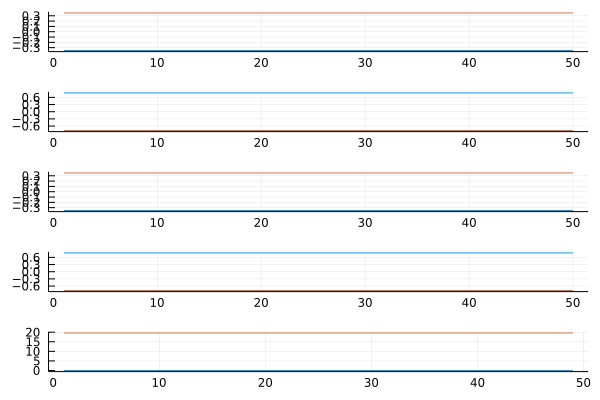

In [244]:
# Test the solver
begin
    println("Starting the solver...")
    # Plotting the comparisons
    Xout, Uout, Fout, Xref = test_traj_opt()
#     println(Xref)
#     println(Uout)
#     println(Fout)
    
    p1 = plot(Xout, inds=1:2)
    p2 = plot(Xout, inds=3:4)
    p3 = plot(Xref, inds=1:2)
    p4 = plot(Xref, inds=3:4)
    p5 = plot(Fout[1:end-1])
    
    
    plot(p1, p2, p3, p4, p5, layout = (5, 1), legend = false)
end
    

In [ ]:
# Test the foot coords. The description for both is from the vertical
begin
    l = 1.0
    t1 = pi + 0.1
    t2 = pi + 0.1
    x0 = [-l/2*sin(t1); l/2*cos(t1); t1; t2; 0.0; 0.0; 0.0; 0.0]
    # println(x0)
    hopper = Hopper(1, 1)
    # fx = foot_coords(hopper, x0)
    h = 0.01
    # regCoords = foot_coords(hopper, fx)
    # println(fx)
    u = [0.0; 0.0]
    λ = [0.0; 0.0]
    ts = 70
    x = x0
    xVals = zeros(ts, length(x))
    xVals[1, :] .= x0
    for i = 2:ts
        newX, newλ = implicit_euler(x, u, λ, h, inair=false)
        # λ = newL
        x = newX
        xVals[i, :] .= x
        # println(x)
        # println(λ)
        #println(kfoot_func(x))
    end
    # println(xVals[end, :])
    # plot(xVals[:, 1], xVals[:, 2])
    # println(xVals[end, 2])
    plot(1:ts, xVals[:, 1])
    plot!(1:ts, xVals[:, 2])
    plot!(1:ts, xVals[:, 3])
    plot!(1:ts, xVals[:, 4])
    println(xVals)
    
    # plot!(1:ts, xVals[:, 5])
    
end

In [ ]:
'''begin
    uSize = 4
    xSize = 8
    lSize = 2
    t1 = pi/4
    t2 = -pi/4
    x0 = [-0.5*sin(t1); 0.5*cos(t1); t1; t2; 0.0; 0.0; 0.0; 0.0]
    # x0[2] = 2.0
    xf = x0
    u0 = zeros(uSize)
    λ0 = zeros(lSize)
    N = 15
    xs = zeros(xSize, N)
    
    tf = N*h
    
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, h; fStart=false)
    println(p.modes)
    gindex = zeros(xSize)
    gindex[2] = 1.0
    # Xref, Uref = ref_traj(p, 0.1)
    
    newY = 0.5*cos(t1)
    for i = 1:N
        if i <= 5 || i >= 11
            xs[:, i] .= x0
        else
            xs[:, i] .= x0
            xs[2, i] = newY
            if i >= 9
                newY = newY - 0.5*9.81*((i-8)*h)^2
            else
                newY = newY + 0.5*9.81*((i-5)*h)^2
            end
        end 
    end
    X = [SVector{8}(x) for x in eachcol(xs)]
    U = [SVector{4}(u0) for i=1:N-1]
    λ = [SVector{2}(λ0) for i=1:N-1]
    c = zeros(num_duals(p))
    Z = pack(p, X, U, λ)
    println(foot_coords(p.model, X[5]))
    # println(X[6])
    # println(stance_constraints(p, Z, c))
    m_nlp = num_duals(p)
    n_nlp = num_primals(p)
    plot(X, inds=1:2)
    
end'''